# PID + Feedforward Control Instructional Notebook - Version 4

This notebook is an instructional guide based on real-world experience tuning PID + Feedforward (FF) controllers for industrial processes. The methodology balances theoretical models with empirical adjustments.

**Version 4 Features:**
- Enhanced process description with cascade control structure
- Nonlinear saturation modeling for product concentration
- External process disturbance simulation with time delays
- More realistic chemical reactor control scenario

In [2]:
# Import Required Libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import TransferFunction, step
from IPython.display import Image, display

## Section 2: Enhanced Process Description - Chemical Reactor Control

This version models a more complex chemical reactor system with cascade control structure and multiple interacting variables.

In [3]:
# Define key variables for chemical reactor system
process_description = {
    "controlled_variable": "Product Concentration (CV201)",
    "manipulated_variable": "Cooling Water Flow (MV203)",
    "disturbance_variable": "Inlet Reactant Temperature (DV205)",
    "secondary_variable": "Reactor Jacket Temperature (CV204)",
    "setpoint_variable": "Desired Product Concentration"
}

# Display process setup
for k, v in process_description.items():
    print(f"{k}: {v}")

print("\n" + "="*60)
print("CHEMICAL REACTOR CONTROL SYSTEM")
print("="*60)

controlled_variable: Product Concentration (CV201)
manipulated_variable: Cooling Water Flow (MV203)
disturbance_variable: Inlet Reactant Temperature (DV205)
secondary_variable: Reactor Jacket Temperature (CV204)
setpoint_variable: Desired Product Concentration

CHEMICAL REACTOR CONTROL SYSTEM


## Section 3: Enhanced Control Strategy Overview

**Advanced Cascade Control Strategy:**

- **Inner loop:** Reactor Jacket Temperature (CV204) controlled by MV203 using a fast-acting PID controller
- **Outer loop:** Product Concentration (CV201) controlled by adjusting the setpoint of the inner loop
- **Feedforward signal:** DV205 compensates for changes in inlet reactant temperature
- **System interactions:** Both CV201 and CV204 depend on MV203, creating coupling effects
- **Nonlinearity:** CV201 exhibits saturation behavior due to reaction rate limitations at high temperatures

**Key Benefits:**
- Improved disturbance rejection
- Better setpoint tracking
- Reduced interaction effects between loops

## Section 4: First-Order Process Model and PID Step Response

We'll start with a basic first-order system model to understand the fundamental behavior before moving to the more complex reactor model.

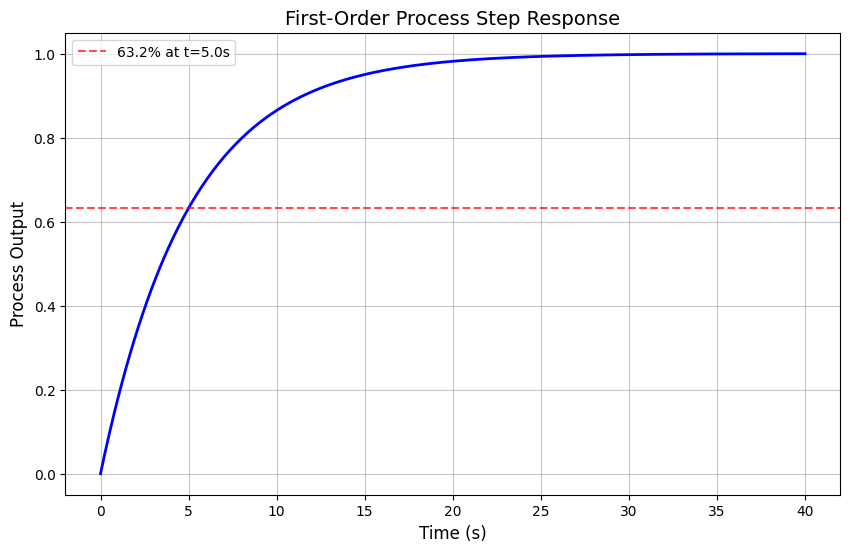

Process gain: 1.0
Time constant: 5.0 seconds
Settling time (98%): ~20.0 seconds


In [4]:
# Define first-order process G(s) = K / (tau*s + 1)
K = 1.0       # Gain
tau = 5.0     # Time constant (seconds)
num = [K]
den = [tau, 1]
G = TransferFunction(num, den)

# Time vector and step response
time = np.linspace(0, 40, 500)
t, y = step(G, T=time)

plt.figure(figsize=(10, 6))
plt.plot(t, y, 'b-', linewidth=2)
plt.title("First-Order Process Step Response", fontsize=14)
plt.xlabel("Time (s)", fontsize=12)
plt.ylabel("Process Output", fontsize=12)
plt.grid(True, alpha=0.7)
plt.axhline(y=0.632*K, color='r', linestyle='--', alpha=0.7, label=f'63.2% at t={tau}s')
plt.legend()
plt.show()

print(f"Process gain: {K}")
print(f"Time constant: {tau} seconds")
print(f"Settling time (98%): ~{4*tau} seconds")

## Section 5: Reactor Jacket Temperature Model (Heat Exchanger)

**Physical Model:** Copper heating coil in reactor jacket with nonlinear power control.

**Key Assumptions:**
- Jacket volume = 0.4 m³, Cooling water flow = 50 L/s (50 kg/s)
- Residence time ≈ 8s
- Power control via firing angle (α): Power ∝ (180 - α)/180
- Heat balance: Q_in = m × Cp × dT/dt - Q_loss
- Heat transfer area ≈ 0.2 m² (estimated from coil geometry)
- Heat losses: Q_loss = U×A×(T - T_ambient), efficiency < 1

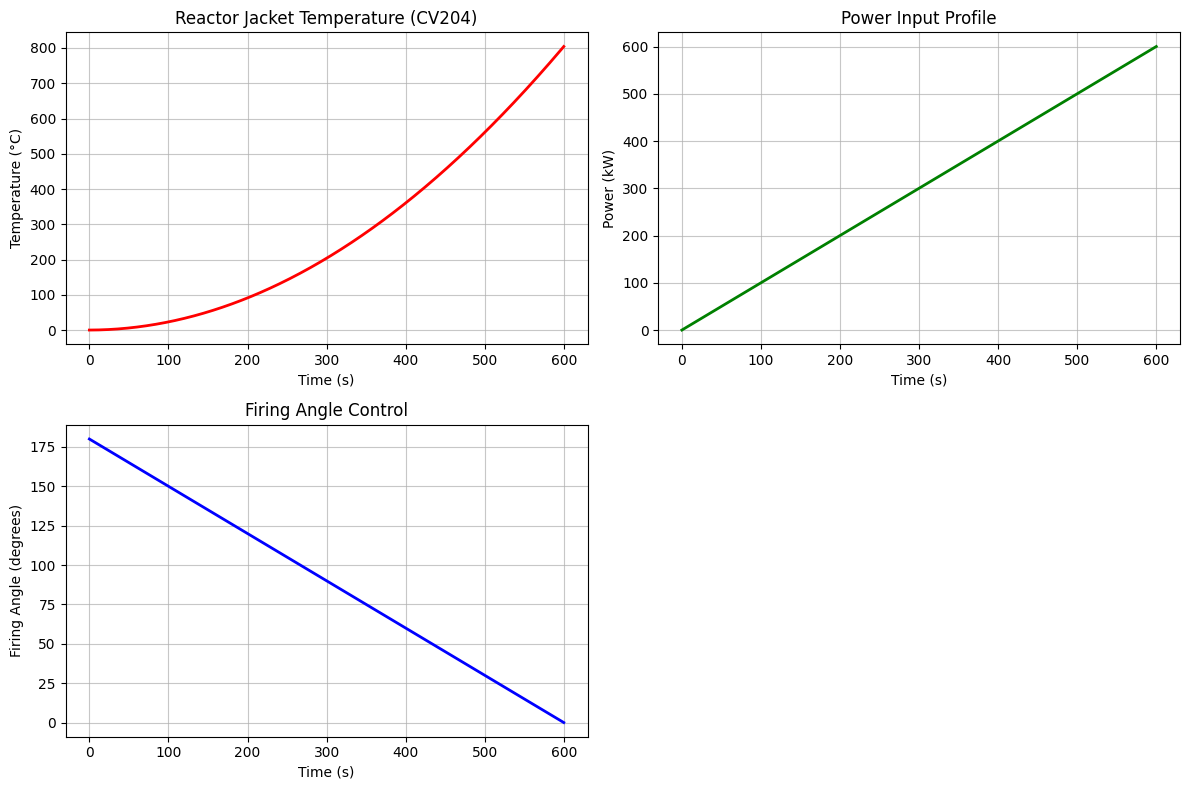

In [6]:
# Reactor jacket parameters
Cp = 4.18       # specific heat (kJ/kg.K)
m = 50.0        # mass flow rate (kg/s)
Pmax = 600.0    # max heater power (kW)
T_ambient = 25  # °C
U = 100         # estimated heat transfer coefficient (W/m²·K)
A = 0.2         # heat exchange area (m²)
efficiency = 0.95

# Time vector for simulation
t = np.linspace(0, 600, 600)
alpha = np.linspace(180, 0, len(t))  # simulate ramp-down of firing angle
power_input = Pmax * (180 - alpha) / 180  # non-linear power mapping

# Simulate jacket temperature (CV204)
T = np.zeros_like(t)
for i in range(1, len(t)):
    Q_loss = U * A * (T[i-1] - T_ambient) / 1000  # convert W to kW
    effective_power = power_input[i] * efficiency
    dTdt = (effective_power - Q_loss) / (m * Cp)
    T[i] = T[i-1] + dTdt

plt.figure(figsize=(12, 8))

# Plot 1: Jacket temperature
plt.subplot(2, 2, 1)
plt.plot(t, T, 'r-', linewidth=2)
plt.title("Reactor Jacket Temperature (CV204)", fontsize=12)
plt.xlabel("Time (s)")
plt.ylabel("Temperature (°C)")  # Fixed missing closing parenthesis
plt.grid(True, alpha=0.7)

# Plot 2: Power input
plt.subplot(2, 2, 2)
plt.plot(t, power_input, 'g-', linewidth=2)
plt.title("Power Input Profile", fontsize=12)
plt.xlabel("Time (s)")
plt.ylabel("Power (kW)")
plt.grid(True, alpha=0.7)

# Plot 3: Firing angle
plt.subplot(2, 2, 3)
plt.plot(t, alpha, 'b-', linewidth=2)
plt.title("Firing Angle Control", fontsize=12)
plt.xlabel("Time (s)")
plt.ylabel("Firing Angle (degrees)")
plt.grid(True, alpha=0.7)

plt.tight_layout()
plt.show()

In [ ]:
# Display heat exchanger image (if available)
try:
    display(Image(filename="heaterinductor.png"))
    print("Heat exchanger configuration shown above")
except FileNotFoundError:
    print("Heat exchanger image (heaterinductor.png) not found in current directory")
    print("This would show the copper coil configuration in the reactor jacket")

## Section 6: Nonlinear Product Concentration Response (CV201)

**Saturation Model:** We simulate the product concentration as a nonlinear function of jacket temperature, mimicking realistic chemical reaction kinetics.

**Mathematical Model:** CV201 = a × T / (b + T)

This represents:
- **Linear region:** At low temperatures, concentration increases nearly linearly with temperature
- **Saturation region:** At high temperatures, reaction rate plateaus due to kinetic limitations
- **Physical meaning:** Represents enzyme saturation, mass transfer limitations, or equilibrium constraints

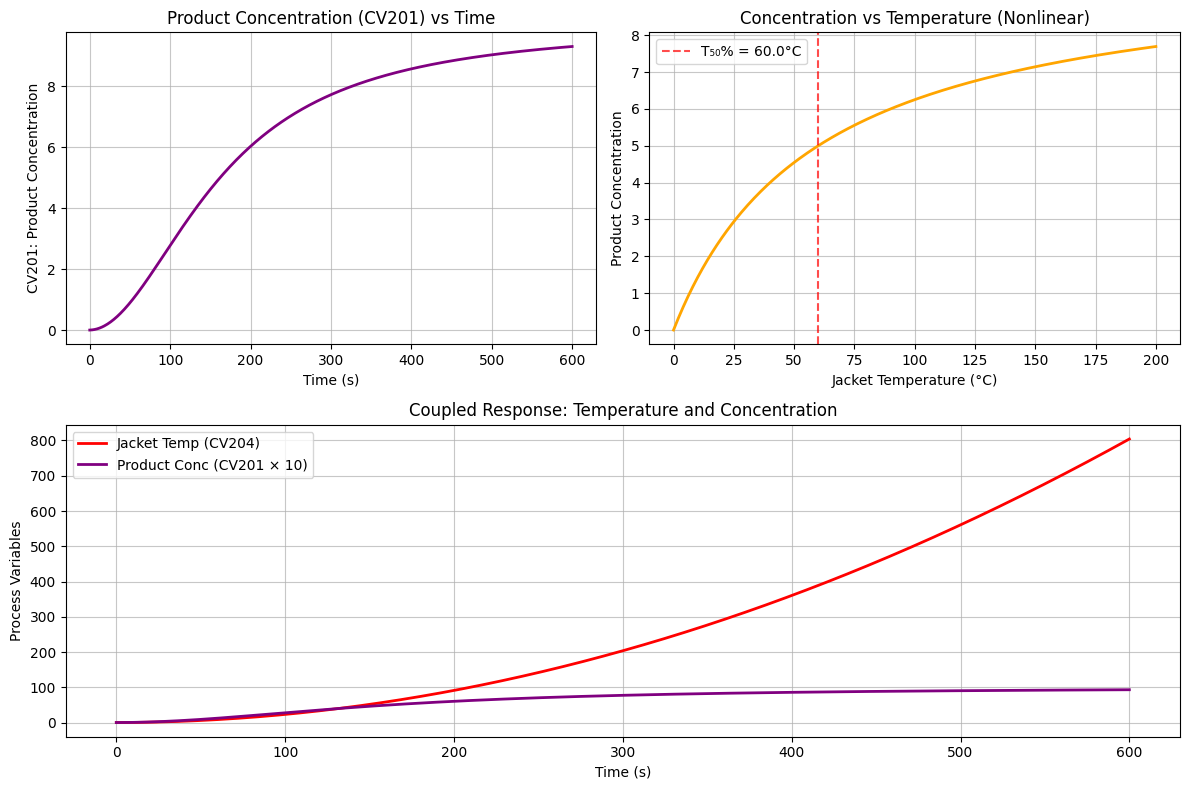

Saturation parameters: a = 10.0, b = 60.0°C
Maximum concentration: 10.0
Temperature for 50% max concentration: 60.0°C


In [7]:
# Nonlinear saturation parameters
a = 10.0  # Maximum concentration factor
b = 60.0  # Temperature for 50% of maximum concentration

# Calculate product concentration as function of jacket temperature
CV201 = a * T / (b + T)  # Saturation-type nonlinearity

plt.figure(figsize=(12, 8))

# Plot 1: Product concentration vs time
plt.subplot(2, 2, 1)
plt.plot(t, CV201, 'purple', linewidth=2)
plt.title("Product Concentration (CV201) vs Time", fontsize=12)
plt.xlabel("Time (s)")
plt.ylabel("CV201: Product Concentration")
plt.grid(True, alpha=0.7)

# Plot 2: Concentration vs temperature (showing nonlinearity)
plt.subplot(2, 2, 2)
temp_range = np.linspace(0, 200, 300)
conc_range = a * temp_range / (b + temp_range)
plt.plot(temp_range, conc_range, 'orange', linewidth=2)
plt.title("Concentration vs Temperature (Nonlinear)", fontsize=12)
plt.xlabel("Jacket Temperature (°C)")
plt.ylabel("Product Concentration")
plt.grid(True, alpha=0.7)
plt.axvline(x=b, color='r', linestyle='--', alpha=0.7, label=f'T₅₀% = {b}°C')
plt.legend()

# Plot 3: Both variables together
plt.subplot(2, 1, 2)
plt.plot(t, T, 'r-', linewidth=2, label='Jacket Temp (CV204)')
plt.plot(t, CV201*10, 'purple', linewidth=2, label='Product Conc (CV201 × 10)')
plt.title("Coupled Response: Temperature and Concentration", fontsize=12)
plt.xlabel("Time (s)")
plt.ylabel("Process Variables")
plt.legend()
plt.grid(True, alpha=0.7)

plt.tight_layout()
plt.show()

print(f"Saturation parameters: a = {a}, b = {b}°C")
print(f"Maximum concentration: {a}")
print(f"Temperature for 50% max concentration: {b}°C")

## Section 7: External Process Disturbance with Time Delay

**Scenario:** Simulation of a separate process startup that affects shared plant utilities or resources.

**Characteristics:**
- **Time delay:** 100 seconds before disturbance begins
- **Ramp duration:** 100 seconds for gradual startup
- **Nonlinear profile:** Quadratic ramp-up profile (realistic for machinery startup)
- **Examples:** Secondary heat exchanger, compressor startup, utility steam demand

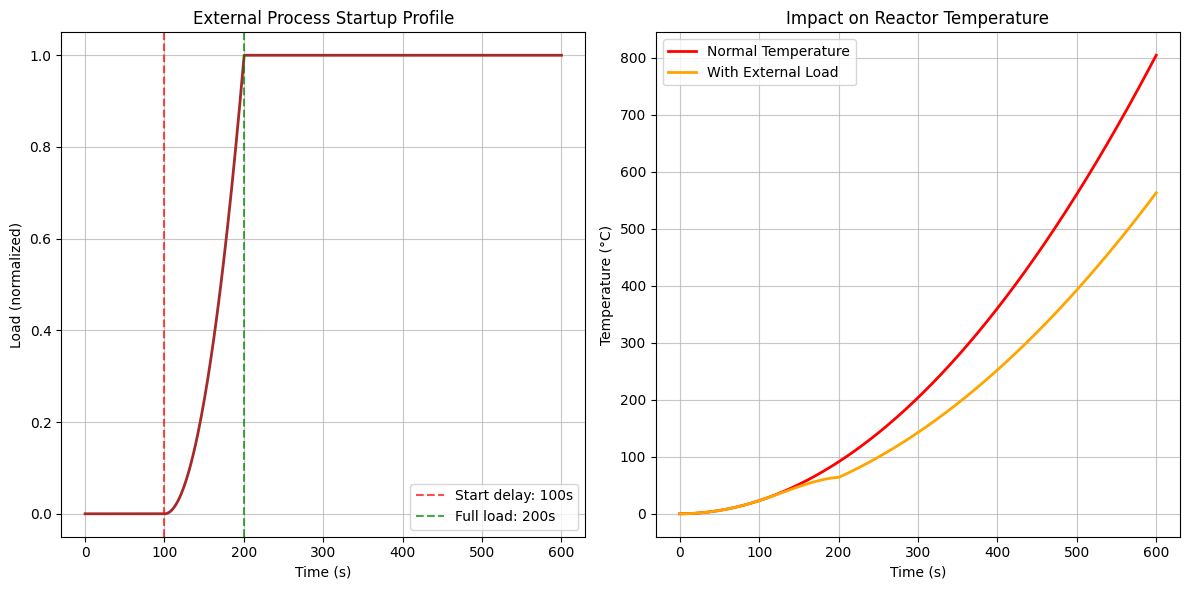

Disturbance timing:
  Start delay: 100 seconds
  Ramp duration: 100 seconds
  Full impact at: 200 seconds


In [8]:
# External disturbance parameters
delay = 100      # seconds before disturbance starts
duration = 100   # seconds for ramp-up
total_time = len(t)
ext_process = np.zeros_like(t)

# Generate external process disturbance profile
for i in range(delay, min(delay + duration, total_time)):
    ext_input = (i - delay) / duration  # normalized time 0 to 1
    ext_process[i] = ext_input ** 2     # quadratic ramp-up

# Maintain steady state after ramp-up
for i in range(delay + duration, total_time):
    ext_process[i] = 1.0

plt.figure(figsize=(12, 6))

# Plot 1: External disturbance profile
plt.subplot(1, 2, 1)
plt.plot(t, ext_process, 'brown', linewidth=2)
plt.title("External Process Startup Profile", fontsize=12)
plt.xlabel("Time (s)")
plt.ylabel("Load (normalized)")
plt.grid(True, alpha=0.7)
plt.axvline(x=delay, color='r', linestyle='--', alpha=0.7, label=f'Start delay: {delay}s')
plt.axvline(x=delay+duration, color='g', linestyle='--', alpha=0.7, label=f'Full load: {delay+duration}s')
plt.legend()

# Plot 2: Impact on reactor system (hypothetical)
plt.subplot(1, 2, 2)
# Simulate impact on cooling capacity (reduces effective cooling)
cooling_impact = 1 - 0.3 * ext_process  # 30% reduction in cooling capacity
effective_temp = T * cooling_impact
plt.plot(t, T, 'r-', linewidth=2, label='Normal Temperature')
plt.plot(t, effective_temp, 'orange', linewidth=2, label='With External Load')
plt.title("Impact on Reactor Temperature", fontsize=12)
plt.xlabel("Time (s)")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.grid(True, alpha=0.7)

plt.tight_layout()
plt.show()

print(f"Disturbance timing:")
print(f"  Start delay: {delay} seconds")
print(f"  Ramp duration: {duration} seconds") 
print(f"  Full impact at: {delay + duration} seconds")

## Section 8: Industrial Power Rectifier Unit

This section displays the industrial power rectifier unit that provides controlled power to the reactor heating system. 

**Key Features:**
- Regulated high-power AC/DC output
- Firing angle control (SCRs or IGBTs)
- Industrial-grade power electronics
- Precise temperature control capability

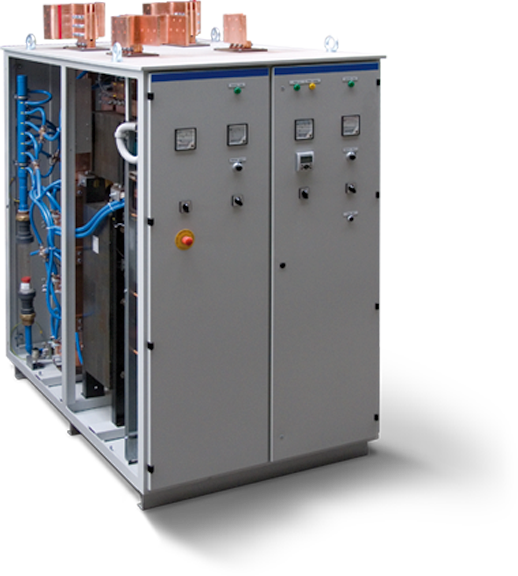

Industrial power rectifier configuration shown above


In [9]:
# Display industrial rectifier image (if available)
try:
    display(Image(filename="rectifier.png"))
    print("Industrial power rectifier configuration shown above")
except FileNotFoundError:
    print("Rectifier image (rectifier.png) not found in current directory")
    print("This would show the industrial power electronics unit used for heating control")

## Section 9: Enhanced Feedforward Modeling

**Objective:** Develop a data-driven model for feedforward compensation from inlet reactant temperature (DV205) to jacket temperature (CV204).

**Approach:**
- Use experimental data to fit: CV204 = a × DV205 + b
- Implement feedforward gain calculation
- Validate model effectiveness

FEEDFORWARD GAIN ANALYSIS
Feedforward gain: 0.8554
Offset: 20.82
R-squared: 0.6477
P-value: 6.25e-24
Standard error: 0.0637


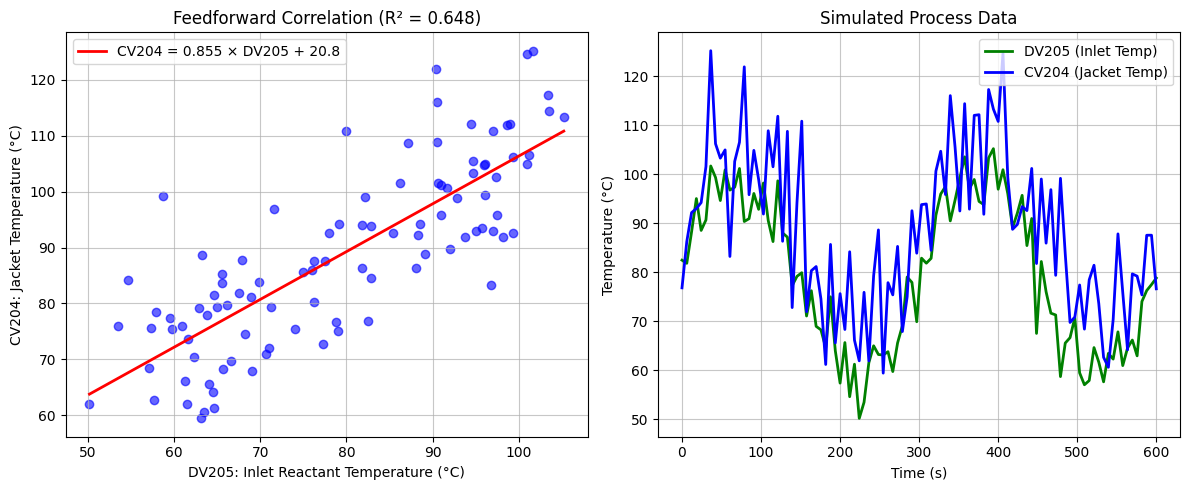

In [11]:
# Enhanced feedforward gain calculation
from scipy import stats

def calculate_feedforward_gain(dv205_data, cv204_data):
    """
    Calculate feedforward gain using linear regression
    CV204 = a * DV205 + b
    Returns the slope 'a' as the feedforward gain
    
    Parameters:
    dv205_data: inlet reactant temperature data
    cv204_data: jacket temperature data
    
    Returns:
    dict: containing gain, offset, correlation coefficient, and p-value
    """
    if len(dv205_data) != len(cv204_data):
        raise ValueError("Input arrays must have the same length")
    
    # Perform linear regression
    slope, intercept, r_value, p_value, std_err = stats.linregress(dv205_data, cv204_data)
    
    results = {
        'feedforward_gain': slope,
        'offset': intercept,
        'correlation_coefficient': r_value,
        'r_squared': r_value**2,
        'p_value': p_value,
        'standard_error': std_err
    }
    
    return results

# Example implementation with simulated data
np.random.seed(42)  # For reproducible results
n_points = 100

# Simulate inlet temperature variations
dv205_sim = 80 + 20 * np.sin(np.linspace(0, 4*np.pi, n_points)) + 5 * np.random.normal(0, 1, n_points)

# Simulate jacket temperature response (with some correlation + noise)
cv204_sim = 0.8 * dv205_sim + 25 + 10 * np.random.normal(0, 1, n_points)

# Calculate feedforward gain
ff_results = calculate_feedforward_gain(dv205_sim, cv204_sim)

# Display results
print("FEEDFORWARD GAIN ANALYSIS")
print("=" * 40)
print(f"Feedforward gain: {ff_results['feedforward_gain']:.4f}")
print(f"Offset: {ff_results['offset']:.2f}")
print(f"R-squared: {ff_results['r_squared']:.4f}")
print(f"P-value: {ff_results['p_value']:.2e}")
print(f"Standard error: {ff_results['standard_error']:.4f}")

# Plot correlation
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(dv205_sim, cv204_sim, alpha=0.6, color='blue')
x_line = np.linspace(min(dv205_sim), max(dv205_sim), 100)
y_line = ff_results['feedforward_gain'] * x_line + ff_results['offset']
plt.plot(x_line, y_line, 'r-', linewidth=2, 
         label=f'CV204 = {ff_results["feedforward_gain"]:.3f} × DV205 + {ff_results["offset"]:.1f}')
plt.xlabel('DV205: Inlet Reactant Temperature (°C)')
plt.ylabel('CV204: Jacket Temperature (°C)')
plt.title(f'Feedforward Correlation (R² = {ff_results["r_squared"]:.3f})')
plt.legend()
plt.grid(True, alpha=0.7)

plt.subplot(1, 2, 2)
time_sim = np.linspace(0, 600, n_points)
plt.plot(time_sim, dv205_sim, 'g-', linewidth=2, label='DV205 (Inlet Temp)')
plt.plot(time_sim, cv204_sim, 'b-', linewidth=2, label='CV204 (Jacket Temp)')
plt.xlabel('Time (s)')
plt.ylabel('Temperature (°C)')
plt.title('Simulated Process Data')
plt.legend()
plt.grid(True, alpha=0.7)

plt.tight_layout()
plt.show()

## Section 10: Next Steps and Advanced Implementation

**Immediate Next Steps:**
- **Symbolic modeling:** Add sympy for advanced mathematical analysis and transfer function manipulation
- **Disturbance simulation:** Implement disturbance injection and feedforward cancellation scenarios
- **Cascade control:** Develop complete cascade control structure with inner/outer loop tuning
- **Interaction analysis:** Model and compensate for variable interactions using decoupling techniques

**Advanced Implementation:**
- **PLC integration:** Convert control algorithms to function blocks suitable for industrial PLCs
- **Real-time testing:** Validate models against actual process data
- **Robustness analysis:** Test controller performance under various operating conditions
- **Optimization:** Implement model predictive control (MPC) for advanced process optimization

**Industrial Considerations:**
- **Safety interlocks:** Implement emergency shutdown and safety limit checking
- **Alarm management:** Design appropriate alarm levels for process monitoring
- **Operator interface:** Develop HMI screens for process visualization and control
- **Documentation:** Create comprehensive tuning procedures and maintenance guidelines

**Performance Metrics:**
- **Control performance:** ISE, IAE, settling time, overshoot analysis
- **Economic performance:** Energy efficiency, product quality improvements
- **Reliability metrics:** Availability, maintenance requirements, failure analysis